In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import layers, models
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
sample_rate = 44100

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    #zcr = librosa.feature.zero_crossing_rate(y=data).T.flatten()
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    #chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sample_rate).T.flatten()
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    #mfcc = librosa.feature.mfcc(y=data, sr=sample_rate).T.flatten()
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    #rms = librosa.feature.rms(y=data).T.flatten()
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    #mel = librosa.feature.melspectrogram(y=data, sr=sample_rate).T.flatten()
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, sr=44100, duration=2, offset=0.5)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    return result

In [ ]:
os.chdir("/content/drive/MyDrive/ML/final/")
PATH = 'TaiwanTornado'
file_dir = os.listdir(PATH)
file_dir.sort()

training_samples = len(file_dir)
X_train = np.zeros([training_samples, 44100*2])
for idx, filename in enumerate(file_dir):
  #audio, sr = librosa.load(os.path.join(PATH, filename), sr = 44100, duration = 3)
  #audio = librosa.util.fix_length(audio, size=132300)
  audio, sample_rate = librosa.load(os.path.join(PATH, filename), sr=44100, duration=2, offset=0.5)
  
  if audio is not None:
      X_train[idx,:] = audio
print(X_train.shape)

(600, 88200)


In [ ]:
data = pd.read_csv("final_label_600.csv", header = None)
y_train = data.to_numpy()
onehotencoder = OneHotEncoder()
y_train = onehotencoder.fit_transform(y_train).toarray()
#y_train = tf.keras.utils.to_categorical(y_train)
#y_train = np.repeat(y_train, repeats=3, axis=0)
print(y_train.shape, np.unique(y_train))
print(y_train[499])

(600, 5) [0. 1.]
[0. 0. 1. 0. 0.]


In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.166)
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
X_test = X_train[500:]
X_train = X_train[0:500]
y_test = y_train[500:]
y_train = y_train[0:500]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(500, 88200) (100, 88200) (500, 5) (100, 5)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(400, 88200) (100, 88200) (400, 5) (100, 5)


In [ ]:
X_train_augmented = np.zeros([X_train.shape[0] * 3, 162])
#X_train_augmented = np.zeros([X_train.shape[0] * 3, 28026])
for idx in range(X_train.shape[0]):
  # without augmentation
  res1 = extract_features(X_train[idx])
  result = np.array(res1)

  # data with noise
  noise_data = noise(X_train[idx])
  res2 = extract_features(noise_data)
  #X_train = np.vstack((X_train, res2)) # stacking vertically

  # data with stretching and pitching
  new_data = stretch(X_train[idx])
  data_stretch_pitch = pitch(new_data, sample_rate)
  res3 = extract_features(data_stretch_pitch)
  #X_train = np.vstack((X_train, res3)) # stacking vertically

  X_train_augmented[3 * idx] = res1
  X_train_augmented[3 * idx + 1] = res2
  X_train_augmented[3 * idx + 2] = res3
X_train = X_train_augmented
y_train = np.repeat(y_train, repeats=3, axis=0)
X_train.shape

(1200, 162)

In [ ]:
X_val_extracted = np.zeros([X_val.shape[0], 162])
#X_val_extracted = np.zeros([X_val.shape[0], 28026])
for idx in range(X_val.shape[0]):
  X_val_extracted[idx] = extract_features(X_val[idx])
X_val = X_val_extracted
X_val.shape

(100, 162)

In [ ]:
X_test_extracted = np.zeros([X_test.shape[0], 162])
#X_val_extracted = np.zeros([X_val.shape[0], 28026])
for idx in range(X_test.shape[0]):
  X_test_extracted[idx] = extract_features(X_test[idx])
X_test = X_test_extracted
X_test.shape

(100, 162)

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(1200, 162, 1)

In [ ]:
model=models.Sequential()
model.add(layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))
#model.add(layers.Dropout(0.2))

#model.add(layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
#model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dense(units=32, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(units=5, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 128)          512       
                                                                 
 batch_normalization (BatchN  (None, 162, 128)         512       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           164096    
                                                                 
 batch_normalization_1 (Batc  (None, 81, 256)          1024      
 hNormalization)                                                 
                                                        

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 30
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size = 64,
    #callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=5, restore_best_weights=True)
)

Epoch 1/30
19/19 [==============================] - 10s 65ms/step - loss: 1.8709 - accuracy: 0.2917 - val_loss: 1.5719 - val_accuracy: 0.3400
Epoch 2/30
19/19 [==============================] - 0s 12ms/step - loss: 1.5648 - accuracy: 0.3275 - val_loss: 1.5843 - val_accuracy: 0.3100
Epoch 3/30
19/19 [==============================] - 0s 12ms/step - loss: 1.4889 - accuracy: 0.3325 - val_loss: 1.6589 - val_accuracy: 0.3300
Epoch 4/30
19/19 [==============================] - 0s 11ms/step - loss: 1.4514 - accuracy: 0.3458 - val_loss: 1.7933 - val_accuracy: 0.2500
Epoch 5/30
19/19 [==============================] - 0s 11ms/step - loss: 1.4487 - accuracy: 0.3383 - val_loss: 2.0489 - val_accuracy: 0.3000
Epoch 6/30
19/19 [==============================] - 0s 11ms/step - loss: 1.3881 - accuracy: 0.3850 - val_loss: 2.0535 - val_accuracy: 0.2900
Epoch 7/30
19/19 [==============================] - 0s 11ms/step - loss: 1.3343 - accuracy: 0.4100 - val_loss: 1.8313 - val_accuracy: 0.3100
Epoch 8/30
1

Text(0, 0.5, 'Accuracy [%]')

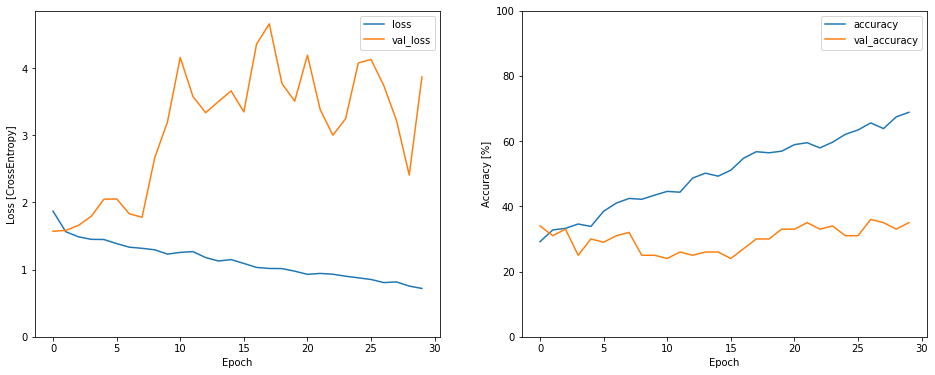

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

4/4 [==============================] - 0s 37ms/step


array([0, 2, 3, 0, 0, 0, 0, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 0, 0, 3,
       0, 0, 0, 3, 0, 0, 0, 3, 0, 3, 3, 0, 0, 0, 2, 2, 3, 2, 3, 0, 3, 0,
       2, 2, 3, 3, 0, 0, 3, 3, 0, 0, 0, 0, 4, 2, 2, 0, 0, 3, 3, 3, 3, 3,
       3, 4, 3, 2, 3, 0, 3, 3, 0, 0, 3, 0, 0, 2, 0, 0, 3, 3, 3, 3, 3, 2,
       3, 3, 0, 3, 0, 4, 0, 1, 1, 1, 0, 0])

In [ ]:
y_check = np.argmax(y_test, axis=1)
y_check

array([2, 3, 3, 0, 0, 0, 2, 2, 3, 2, 2, 3, 1, 4, 3, 3, 3, 2, 0, 4, 0, 3,
       0, 0, 0, 3, 4, 4, 4, 3, 4, 4, 3, 4, 2, 2, 2, 2, 3, 2, 3, 0, 0, 0,
       0, 2, 3, 4, 0, 0, 3, 3, 2, 1, 2, 0, 4, 0, 4, 4, 2, 3, 4, 4, 3, 4,
       4, 1, 0, 2, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 4, 4, 3, 2, 4, 0, 4,
       4, 4, 0, 3, 1, 2, 2, 1, 4, 4, 1, 4])

In [ ]:
loss,accuracy=model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Test Loss: 2.531418561935425
Test Accuracy: 0.4399999976158142


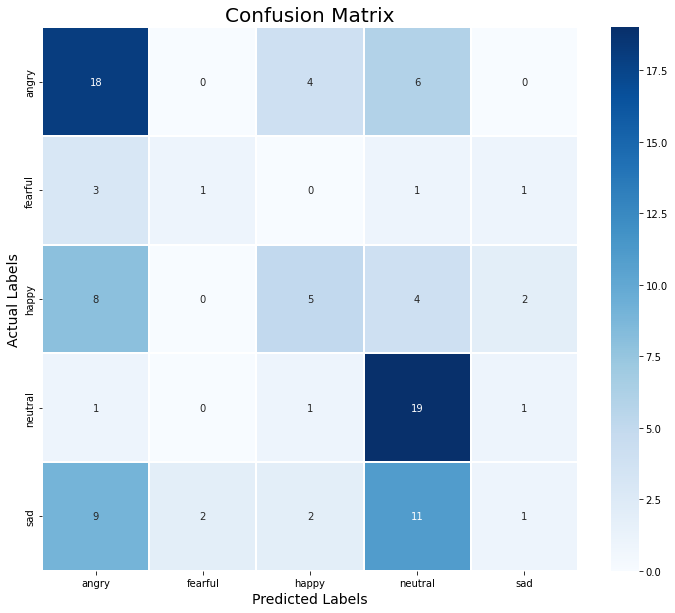

In [ ]:
cm = confusion_matrix(y_check, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in onehotencoder.categories_] , columns = [i for i in onehotencoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
#onehotencoder.inverse_transform(np.arange(y_pred))
#print(onehotencoder.categories_[0])
print(classification_report(y_check, y_pred, target_names=onehotencoder.categories_[0]))

              precision    recall  f1-score   support

       angry       0.50      0.73      0.59        26
     fearful       0.38      0.30      0.33        10
       happy       0.40      0.14      0.21        14
     neutral       0.63      0.83      0.72        23
         sad       0.53      0.37      0.43        27

    accuracy                           0.53       100
   macro avg       0.49      0.47      0.46       100
weighted avg       0.51      0.53      0.50       100



In [ ]:
#model.save('/content/drive/MyDrive/ML/final/saved_model/categorical.h5')